# Interest rate modeling using CIR - USDC vs WETH (AAVE V3)

### The strategy exemplified here is: lend USDC, borrow WETH

**Data: AAVE V3 from data/AAVE folder (aave_v3_usdc_eth.csv, aave_v3_weth_eth.csv)**

**The point here is that $\theta$ spread [$\theta$ from CIR (mean to which the interest rates revert to)] has to be greater than the volatility drag, unless our assets have really low or even negative correlation or low volatility. Otherwise we don't earn anything from the APY spread of the two tokens**

We could look into tokens with low correlation or less volatile


I'm looking into how we should deal with correlation and tail risk

I think we should also consider rebalancing, static portfolio might be unrealistic

In [ ]:
#TODO model colateral factor, look into it, fit APR into h(t) or W(t) or do we assume static

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from log_health import HealthProcessParameters
from pathlib import Path
from IPython.display import display

In [12]:
def find_repo_root(start: Path = None) -> Path:
    p = Path.cwd() if start is None else Path(start)
    for d in [p] + list(p.parents):
        if (d / 'pyproject.toml').exists() or (d / '.git').exists():
            return d
    return p
repo_root = find_repo_root()
plots_dir = repo_root / 'results' / 'plots'

In [13]:
# Ensure Path.cwd() returns the repo root so later cells don't accidentally use src as root
_repo_root = find_repo_root()
Path.cwd = classmethod(lambda cls: _repo_root)
repo_root = _repo_root
plots_dir = repo_root / 'results' / 'plots'

**AAVE V3: Lender Variable APR (USDC) & Borrower Variable APR (WETH) Visualizations & descriptive stats**


Loaded aave_v3_usdc_eth.csv: (26208, 12)
Date range: 2023-01-27 08:00:00 to 2026-01-23 07:00:00


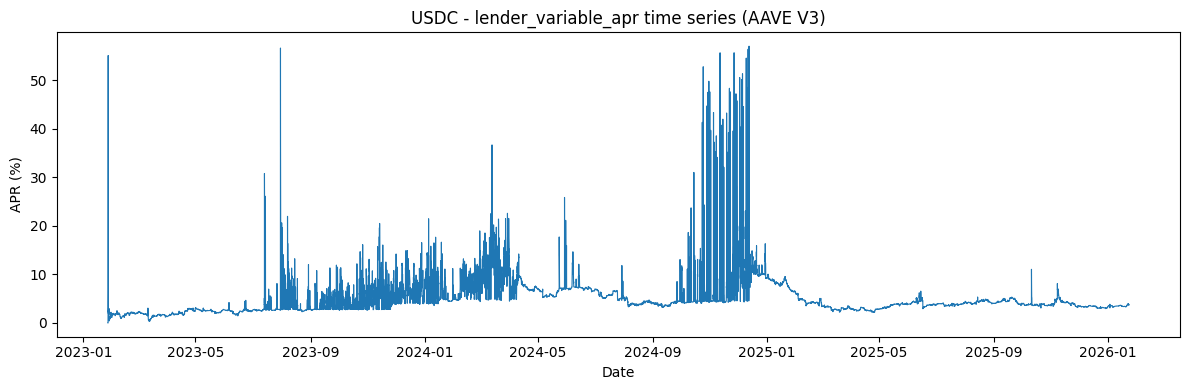


Summary for USDC (lender_variable_apr):
                       count      mean    median      std  min        max
lender_variable_apr  26207.0  4.976187  4.066623  3.33477  0.0  57.066085

Loaded aave_v3_weth_eth.csv: (26208, 12)
Date range: 2023-01-27 08:00:00 to 2026-01-23 07:00:00


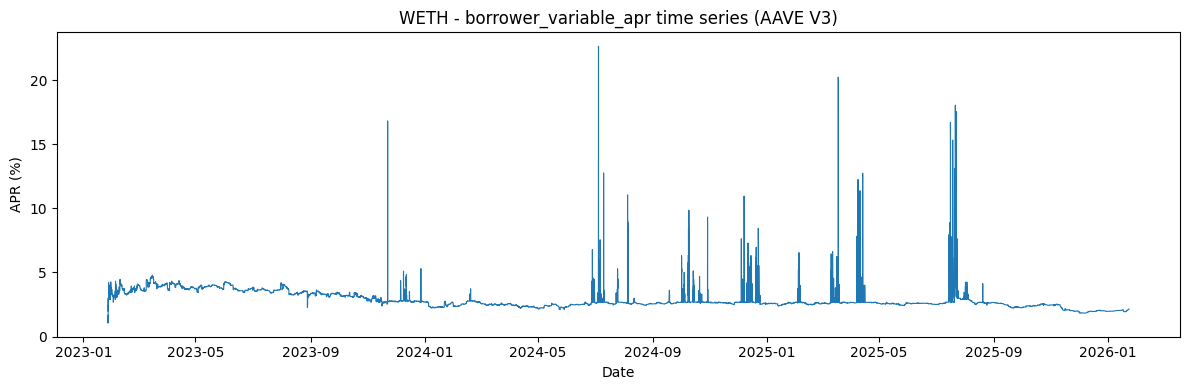


Summary for WETH (borrower_variable_apr):
                         count     mean    median       std       min  \
borrower_variable_apr  26207.0  2.86115  2.643411  0.746176  1.064176   

                             max  
borrower_variable_apr  22.643545  


In [14]:
# Load AAVE V3 data: USDC lender variable APR and WETH borrower variable APR
data_dir = repo_root / 'data' / 'AAVE'
files = {
    'USDC': ('aave_v3_usdc_eth.csv', 'lender_variable_apr'),
    'WETH': ('aave_v3_weth_eth.csv', 'borrower_variable_apr')
}

for asset, (fn, col) in files.items():
    fp = str(data_dir / fn)
    # First column is unnamed index, use index_col=0
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    # Parse the index as timestamps
    df.index = pd.to_datetime(df.index)
    print(f'\nLoaded {fn}:', df.shape)
    print(f'Date range: {df.index.min()} to {df.index.max()}')
    
    if col not in df.columns:
        print(f'{fn}: column {col} not found. Available columns: {df.columns.tolist()}')
        continue
    
    s = pd.to_numeric(df[col], errors='coerce')
    
    # Time series plot only
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    
    ax.plot(df.index, s, lw=0.8)
    ax.set_title(f'{asset} - {col} time series (AAVE V3)')
    ax.set_xlabel('Date')
    ax.set_ylabel('APR (%)')
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    s_clean = s.dropna()
    summary = {
        col: {
            'count': int(s_clean.count()),
            'mean': float(s_clean.mean()),
            'median': float(s_clean.median()),
            'std': float(s_clean.std()),
            'min': float(s_clean.min()),
            'max': float(s_clean.max())
        }
    }
    print(f'\nSummary for {asset} ({col}):')
    print(pd.DataFrame(summary).T.round(6))

**CIR estimation for USDC lender rate and WETH borrower rate (AAVE V3, separate models)**

The cells below estimate CIR models separately for:
- USDC `lender_variable_apr` (supply/lending rate)
- WETH `borrower_variable_apr` (borrow rate)

Fitting both the Euler/GMM-style estimator and the exact MLE (non-central chi-square transition) implemented in `src/cir_model.py` for the full sample and for selected periods.

**Data source: AAVE V3 hourly data from data/AAVE folder**

In [15]:
import sys
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robustly import cir_model: reload if present, otherwise load from source file
import importlib, importlib.util
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)

In [16]:
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robust import of cir_model
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)

# Load AAVE V3 data files
fp_usdc = repo_root / 'data' / 'AAVE' / 'aave_v3_usdc_eth.csv'
fp_weth = repo_root / 'data' / 'AAVE' / 'aave_v3_weth_eth.csv'
out_dir = repo_root / 'results'
out_dir.mkdir(parents=True, exist_ok=True)
rows = []

if not fp_usdc.exists() or not fp_weth.exists():
    print('Missing input CSVs at', fp_usdc, fp_weth)
else:
    # Load data - first column is unnamed index
    df_usdc = pd.read_csv(fp_usdc, index_col=0, parse_dates=True)
    df_usdc.index = pd.to_datetime(df_usdc.index)
    
    df_weth = pd.read_csv(fp_weth, index_col=0, parse_dates=True)
    df_weth.index = pd.to_datetime(df_weth.index)
    
    if 'lender_variable_apr' not in df_usdc.columns or 'borrower_variable_apr' not in df_weth.columns:
        print('Required columns missing in inputs')
        print(f'USDC columns: {df_usdc.columns.tolist()}')
        print(f'WETH columns: {df_weth.columns.tolist()}')
    else:
        series_defs = {
            'USDC_lend': (df_usdc['lender_variable_apr'], 'USDC'),
            'WETH_borrow': (df_weth['borrower_variable_apr'], 'WETH')
        }
        
        def infer_dt(idx):
            """Infer time step in years from datetime index (hourly data)."""
            if not isinstance(idx, pd.DatetimeIndex) or len(idx) < 2:
                return 1.0 / (365.0 * 24)  # hourly default
            median_sec = idx.to_series().diff().dt.total_seconds().median()
            if pd.isna(median_sec) or median_sec <= 0:
                return 1.0 / (365.0 * 24)
            return float(median_sec) / (3600 * 24 * 365)
        
        for name, (ser, asset_label) in series_defs.items():
            s = pd.to_numeric(ser, errors='coerce').dropna()
            if s.empty:
                rows.append({'series': name, 'asset': asset_label, 'period': 'FULL', 'n': 0})
                continue
            dt = infer_dt(s.index)
            try:
                efit = cir_model.fit_cir_euler(s.values, dt)
            except Exception as ex:
                efit = None
                print('Euler fit error', name, ex)
            try:
                mfit = cir_model.fit_cir_mle(s.values, dt)
            except Exception as ex:
                mfit = None
                print('MLE fit error', name, ex)
            row = dict(series=name, asset=asset_label, period='FULL', n=len(s), dt=dt)
            if efit:
                row.update({'e_kappa': efit.get('kappa'), 'e_theta': efit.get('theta'), 'e_sigma': efit.get('sigma')})
            if mfit:
                row.update({'m_kappa': mfit.get('kappa'), 'm_theta': mfit.get('theta'), 'm_sigma': mfit.get('sigma'), 'm_success': mfit.get('success')})
            rows.append(row)
        
        out_df = pd.DataFrame(rows)
        out_fp = out_dir / 'cir_usdc_weth_aave_v3.csv'
        out_df.to_csv(out_fp, index=False)
        print(f'Saved CIR results to {out_fp}')
        display(out_df.round(6))

Saved CIR results to /Users/tedig/Defi_interestRate/results/cir_usdc_weth_aave_v3.csv


,series,asset,period,n,dt,e_kappa,e_theta,e_sigma,m_kappa,m_theta,m_sigma,m_success
0,USDC_lend,USDC,FULL,26207,0.000114,2088.663589,4.976829,90.668636,18.451803,2.0,10.0,True
1,WETH_borrow,WETH,FULL,26207,0.000114,1399.342281,2.861435,22.378199,113.795301,2.0,10.0,True


In [17]:
# Volatility Drag: σ_h² = var(ln(USDC) - ln(WETH))
# Compute volatility from actual price data for both USDC and WETH

repo_root = find_repo_root()

print("Computing volatility drag for USDC (lend) / WETH (borrow) strategy...")
print("="*60)

# Load both USDC and WETH price data from AAVE files
fp_usdc = repo_root / 'data' / 'AAVE' / 'aave_v3_usdc_eth.csv'
fp_weth = repo_root / 'data' / 'AAVE' / 'aave_v3_weth_eth.csv'

hours_per_year = 365.25 * 24
q_low, q_high = 0.01, 0.99

sigma_usdc = None
sigma_weth = None
usdc_returns = None
weth_returns = None

# Load USDC price data
if fp_usdc.exists():
    df_usdc = pd.read_csv(fp_usdc, index_col=0, parse_dates=True)
    df_usdc.index = pd.to_datetime(df_usdc.index)
    
    if 'close' in df_usdc.columns:
        prices_usdc = pd.to_numeric(df_usdc['close'], errors='coerce').dropna()
        prices_usdc = prices_usdc[prices_usdc > 0]
        
        # Calculate log returns
        log_returns_usdc = np.log(prices_usdc / prices_usdc.shift(1)).dropna()
        
        # Filter out extreme returns
        low = log_returns_usdc.quantile(q_low)
        high = log_returns_usdc.quantile(q_high)
        usdc_returns = log_returns_usdc[(log_returns_usdc >= low) & (log_returns_usdc <= high)]
        
        # Annualized volatility
        sigma_usdc_hourly = float(usdc_returns.std())
        sigma_usdc = sigma_usdc_hourly * np.sqrt(hours_per_year)
        print(f"\nUSDC volatility (from {len(usdc_returns)} hourly returns):")
        print(f"  σ_USDC (hourly) = {sigma_usdc_hourly:.8f}")
        print(f"  σ_USDC (annual) = {sigma_usdc:.6f}")
    else:
        print("Error: 'close' column not found in USDC data")
else:
    print(f"Error: USDC data not found at {fp_usdc}")

# Load WETH price data
if fp_weth.exists():
    df_weth = pd.read_csv(fp_weth, index_col=0, parse_dates=True)
    df_weth.index = pd.to_datetime(df_weth.index)
    
    if 'close' in df_weth.columns:
        prices_weth = pd.to_numeric(df_weth['close'], errors='coerce').dropna()
        prices_weth = prices_weth[prices_weth > 0]
        
        # Calculate log returns
        log_returns_weth = np.log(prices_weth / prices_weth.shift(1)).dropna()
        
        # Filter out extreme returns
        low = log_returns_weth.quantile(q_low)
        high = log_returns_weth.quantile(q_high)
        weth_returns = log_returns_weth[(log_returns_weth >= low) & (log_returns_weth <= high)]
        
        # Annualized volatility
        sigma_weth_hourly = float(weth_returns.std())
        sigma_weth = sigma_weth_hourly * np.sqrt(hours_per_year)
        print(f"\nWETH volatility (from {len(weth_returns)} hourly returns):")
        print(f"  σ_WETH (hourly) = {sigma_weth_hourly:.8f}")
        print(f"  σ_WETH (annual) = {sigma_weth:.6f}")
    else:
        print("Error: 'close' column not found in WETH data")
else:
    print(f"Error: WETH data not found at {fp_weth}")

# Compute correlation and volatility drag
if sigma_usdc is not None and sigma_weth is not None and usdc_returns is not None and weth_returns is not None:
    # Align returns by index to compute correlation
    aligned = pd.concat([usdc_returns.rename('USDC'), weth_returns.rename('WETH')], axis=1).dropna()
    rho = float(aligned['USDC'].corr(aligned['WETH']))
    
    print(f"\nCorrelation (from {len(aligned)} aligned returns):")
    print(f"  ρ (USDC, WETH) = {rho:.6f}")
    
    # Volatility drag: σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC
    sigma_h2 = sigma_weth**2 + sigma_usdc**2 - 2.0 * rho * sigma_weth * sigma_usdc
    
    print(f"\nVolatility Drag (σ_h²):")
    print(f"  σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC")
    print(f"  σ_h² = {sigma_weth:.6f}² + {sigma_usdc:.6f}² - 2×{rho:.6f}×{sigma_weth:.6f}×{sigma_usdc:.6f}")
    print(f"  σ_h² = {sigma_h2:.6f}")
else:
    print("\nError: Could not compute volatility drag - missing data")
    sigma_h2 = float('nan')

# Calculate μ_h using θ_USDC - θ_WETH as the drift component from interest rates
print("\n" + "="*60)
print("DRIFT CALCULATION: μ_h = (θ_USDC - θ_WETH) - 0.5 * σ_h²")
print("="*60)

if not np.isnan(sigma_h2):
    # Load USDC and WETH CIR results
    separate_fp = repo_root / 'results' / 'cir_usdc_weth_aave_v3.csv'
    if separate_fp.exists():
        df_sep = pd.read_csv(separate_fp)
        
        print(f"\nUsing σ_h² = {sigma_h2:.6f}")
        print(f"Half variance term: 0.5 * σ_h² = {0.5 * sigma_h2:.6f}")
        
        # Get USDC theta (FULL period only)
        usdc_row = df_sep[df_sep['asset'] == 'USDC']
        weth_row = df_sep[df_sep['asset'] == 'WETH']
        
        theta_usdc = None
        theta_weth = None
        usdc_method = None
        weth_method = None
        
        if not usdc_row.empty:
            row = usdc_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_usdc = row['m_theta']
                usdc_method = "MLE"
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_usdc = row['e_theta']
                usdc_method = "Euler"
                
        if not weth_row.empty:
            row = weth_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_weth = row['m_theta']
                weth_method = "MLE"
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_weth = row['e_theta']
                weth_method = "Euler"
        
        if theta_usdc is not None and theta_weth is not None:
            theta_spread = theta_usdc - theta_weth
            mu_h = theta_spread - 0.5 * sigma_h2
            print(f"\nResults for full period:")
            print(f"  θ_USDC = {theta_usdc:.6f} ({usdc_method})")
            print(f"  θ_WETH = {theta_weth:.6f} ({weth_method})")
            print(f"  θ_spread (USDC - WETH) = {theta_spread:.6f}")
            print(f"  μ_h = θ_spread - 0.5×σ_h² = {theta_spread:.6f} - {0.5 * sigma_h2:.6f} = {mu_h:.6f}")
        else:
            print(f"Missing theta estimates (USDC: {theta_usdc}, WETH: {theta_weth})")
                
    else:
        print(f"CIR results not found at {separate_fp}")
        print("Run the CIR fitting cell first to generate cir_usdc_weth_aave_v3.csv")
else:
    print("Cannot calculate μ_h: σ_h² is not available")

Computing volatility drag for USDC (lend) / WETH (borrow) strategy...



USDC volatility (from 25680 hourly returns):
  σ_USDC (hourly) = 0.00000480
  σ_USDC (annual) = 0.000450

WETH volatility (from 25680 hourly returns):
  σ_WETH (hourly) = 0.00520275
  σ_WETH (annual) = 0.487118

Correlation (from 25166 aligned returns):
  ρ (USDC, WETH) = 0.003049

Volatility Drag (σ_h²):
  σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC
  σ_h² = 0.487118² + 0.000450² - 2×0.003049×0.487118×0.000450
  σ_h² = 0.237283

DRIFT CALCULATION: μ_h = (θ_USDC - θ_WETH) - 0.5 * σ_h²

Using σ_h² = 0.237283
Half variance term: 0.5 * σ_h² = 0.118641

Results for full period:
  θ_USDC = 2.000000 (MLE)
  θ_WETH = 2.000000 (MLE)
  θ_spread (USDC - WETH) = 0.000000
  μ_h = θ_spread - 0.5×σ_h² = 0.000000 - 0.118641 = -0.118641


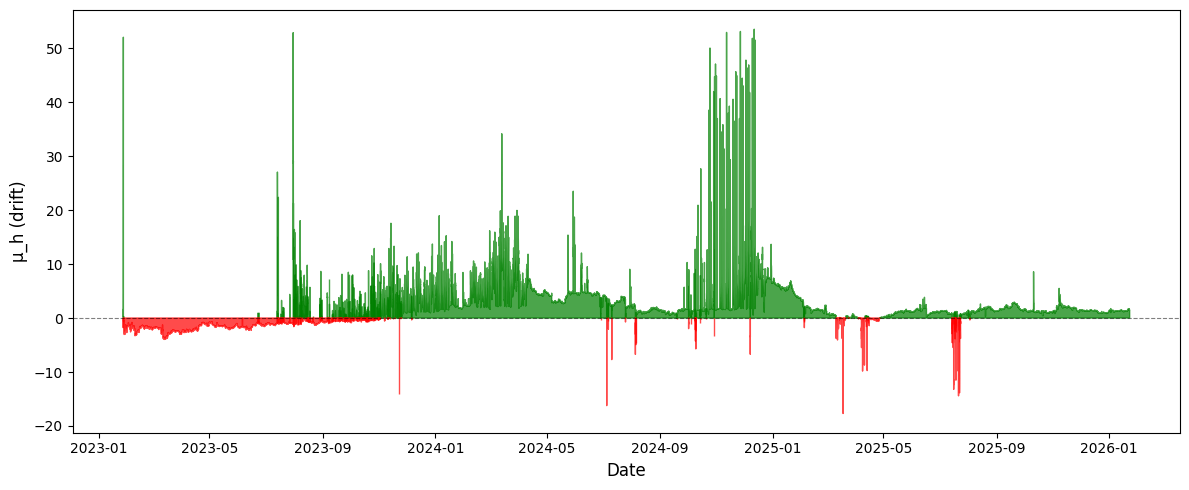


Drift (μ_h) Statistics:
  Mean       = 1.996396
  Median     = 1.400119
  Std        = 3.570001
  % Positive = 75.01%

Volatility drag: 0.5 × σ_h² = 0.118641


In [18]:
# Plot μ_h (drift) for entire period - green above 0, red below 0

# Compute theta spread and drift from aligned rates (already available)
theta_spread_ts = aligned_rates['usdc_rate'] - aligned_rates['weth_rate']
drift_ts = theta_spread_ts - 0.5 * sigma_h2

fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Plot positive values in green
pos_mask = drift_ts.values >= 0
neg_mask = drift_ts.values < 0

ax.fill_between(drift_ts.index, drift_ts.values, 0, 
                where=pos_mask, color='green', alpha=0.7)
ax.fill_between(drift_ts.index, drift_ts.values, 0, 
                where=neg_mask, color='red', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('μ_h (drift)', fontsize=12)
ax.grid(False)
plt.tight_layout()

outp = repo_root / 'results' / 'plots' / 'drift_time_series_colored.png'
outp.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(outp, bbox_inches='tight', transparent=True)
plt.show()

# Summary statistics
print(f"\nDrift (μ_h) Statistics:")
print(f"  Mean       = {drift_ts.mean():.6f}")
print(f"  Median     = {drift_ts.median():.6f}")
print(f"  Std        = {drift_ts.std():.6f}")
print(f"  % Positive = {(drift_ts > 0).mean() * 100:.2f}%")
print(f"\nVolatility drag: 0.5 × σ_h² = {0.5 * sigma_h2:.6f}")